# Multi-VAE
- Multi VAE에 감독 선호도를 반영한 노트북입니다. 
- Focal loss 역시 해당 노트북에서 실험해보았습니다.

## 1. 초기 세팅

In [1]:
## 전처리과정에서 pandas의 버전에 다르게 동작하는 경향이 보여, 이 미션에서는 아래 버전으로 사용하도록하겠습니다.
!pip install pandas==1.0.1

In [1]:
import argparse
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import bottleneck as bn
import torch.nn.functional as F
import adabound

%matplotlib inline


## 데이터 다운로드
이곳에 대회 사이트(AI Stages)에 있는 data의 URL을 입력해주세요. 
- 데이터 URL은 변경될 수 있습니다.
- 예) `!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz`

In [2]:
## 각종 파라미터 세팅
parser = argparse.ArgumentParser(description='PyTorch Variational Autoencoders for Collaborative Filtering')


parser.add_argument('--data', type=str, default='data/train/',
                    help='Movielens dataset location')

parser.add_argument('--lr', type=float, default=1e-4,
                    help='initial learning rate')
parser.add_argument('--wd', type=float, default=0.00,
                    help='weight decay coefficient')
parser.add_argument('--batch_size', type=int, default=1600,#500,
                    help='batch size')
parser.add_argument('--epochs', type=int, default=20, #원래 20
                    help='upper epoch limit')
parser.add_argument('--total_anneal_steps', type=int, default=200000,
                    help='the total number of gradient updates for annealing')
parser.add_argument('--anneal_cap', type=float, default=0.2,
                    help='largest annealing parameter')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed')
parser.add_argument('--cuda', action='store_true',
                    help='use CUDA')
parser.add_argument('--log_interval', type=int, default=100, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str, default='model.pt',
                    help='path to save the final model')
args = parser.parse_args([])

# Set the random seed manually for reproductibility.
torch.manual_seed(args.seed)

#만약 GPU가 사용가능한 환경이라면 GPU를 사용
if torch.cuda.is_available():
    args.cuda = True

device = torch.device("cuda" if args.cuda else "cpu")
device

device(type='cuda')

## 2. 데이터 전처리

In [3]:
import os
import pandas as pd
from scipy import sparse
import numpy as np

def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()

    return count

# 특정한 횟수 이상의 리뷰가 존재하는(사용자의 경우 min_uc 이상, 아이템의 경우 min_sc이상) 
# 데이터만을 추출할 때 사용하는 함수입니다.
# 현재 데이터셋에서는 결과적으로 원본그대로 사용하게 됩니다.
def filter_triplets(tp, min_uc=5, min_sc=0):
    if min_sc > 0:
        itemcount = get_count(tp, 'item')
        tp = tp[tp['item'].isin(itemcount.index[itemcount >= min_sc])]

    if min_uc > 0:
        usercount = get_count(tp, 'user')
        tp = tp[tp['user'].isin(usercount.index[usercount >= min_uc])]

    usercount, itemcount = get_count(tp, 'user'), get_count(tp, 'item')
    return tp, usercount, itemcount

#훈련된 모델을 이용해 검증할 데이터를 분리하는 함수입니다.
#100개의 액션이 있다면, 그중에 test_prop 비율 만큼을 비워두고, 그것을 모델이 예측할 수 있는지를
#확인하기 위함입니다.
def split_train_test_proportion(data, test_prop=0.2): #원래 0.2
    data_grouped_by_user = data.groupby('user')
    tr_list, te_list = list(), list()

    np.random.seed(98765)
    
    for _, group in data_grouped_by_user:
        n_items_u = len(group)
        
        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        
        else:
            tr_list.append(group)
    
    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)

    return data_tr, data_te

def numerize(tp, profile2id, show2id):
    uid = tp['user'].apply(lambda x: profile2id[x])
    sid = tp['item'].apply(lambda x: show2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [4]:
print("Load and Preprocess Movielens dataset")
# Load Data
DATA_DIR = args.data
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train_ratings.csv'), header=0)
print("원본 데이터\n", raw_data)

# Filter Data
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc=5, min_sc=0)
#제공된 훈련데이터의 유저는 모두 5개 이상의 리뷰가 있습니다.
print("5번 이상의 리뷰가 있는 유저들로만 구성된 데이터\n",raw_data)

print("유저별 리뷰수\n",user_activity)
print("아이템별 리뷰수\n",item_popularity)

Load and Preprocess Movielens dataset
원본 데이터
            user   item        time
0            11   4643  1230782529
1            11    170  1230782534
2            11    531  1230782539
3            11    616  1230782542
4            11   2140  1230782563
...         ...    ...         ...
5154466  138493  44022  1260209449
5154467  138493   4958  1260209482
5154468  138493  68319  1260209720
5154469  138493  40819  1260209726
5154470  138493  27311  1260209807

[5154471 rows x 3 columns]
5번 이상의 리뷰가 있는 유저들로만 구성된 데이터
            user   item        time
0            11   4643  1230782529
1            11    170  1230782534
2            11    531  1230782539
3            11    616  1230782542
4            11   2140  1230782563
...         ...    ...         ...
5154466  138493  44022  1260209449
5154467  138493   4958  1260209482
5154468  138493  68319  1260209720
5154469  138493  40819  1260209726
5154470  138493  27311  1260209807

[5154471 rows x 3 columns]
유저별 리뷰수
 user
11        376
1

In [5]:
# Shuffle User Indices
unique_uid = user_activity.index
print("(BEFORE) unique_uid:",unique_uid)
np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]
print("(AFTER) unique_uid:",unique_uid)

n_users = unique_uid.size #31360
n_heldout_users = 3136#3000


# Split Train/Validation/Test User Indices
tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

#주의: 데이터의 수가 아닌 사용자의 수입니다!
print("훈련 데이터에 사용될 사용자 수:", len(tr_users))
print("검증 데이터에 사용될 사용자 수:", len(vd_users))
print("테스트 데이터에 사용될 사용자 수:", len(te_users))



(BEFORE) unique_uid: Int64Index([    11,     14,     18,     25,     31,     35,     43,     50,
                58,     60,
            ...
            138459, 138461, 138470, 138471, 138472, 138473, 138475, 138486,
            138492, 138493],
           dtype='int64', name='user', length=31360)
(AFTER) unique_uid: Int64Index([ 27968,  67764,   2581,  82969, 137831,  48639,  97870,  40424,
             46835,  79570,
            ...
            114284,   9009,  21165,  33920,  22054, 135379, 125855,  41891,
             15720,  17029],
           dtype='int64', name='user', length=31360)
훈련 데이터에 사용될 사용자 수: 25088
검증 데이터에 사용될 사용자 수: 3136
테스트 데이터에 사용될 사용자 수: 3136


In [6]:
##훈련 데이터에 해당하는 아이템들
#Train에는 전체 데이터를 사용합니다.
train_plays = raw_data.loc[raw_data['user'].isin(tr_users)]

##아이템 ID
unique_sid = pd.unique(train_plays['item'])

show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [7]:


# #Validation과 Test에는 input으로 사용될 tr 데이터와 정답을 확인하기 위한 te 데이터로 분리되었습니다.
# vad_plays = raw_data.loc[raw_data['user'].isin(vd_users)]
# vad_plays = vad_plays.loc[vad_plays['item'].isin(unique_sid)]
# vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

# test_plays = raw_data.loc[raw_data['user'].isin(te_users)]
# test_plays = test_plays.loc[test_plays['item'].isin(unique_sid)]
# test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)



# train_data = numerize(train_plays, profile2id, show2id)
# train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)


# vad_data_tr = numerize(vad_plays_tr, profile2id, show2id)
# vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

# vad_data_te = numerize(vad_plays_te, profile2id, show2id)
# vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

# test_data_tr = numerize(test_plays_tr, profile2id, show2id)
# test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

# test_data_te = numerize(test_plays_te, profile2id, show2id)
# test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

# print("Done!")

##3. 데이터 로더 설정

In [9]:

class DataLoader():
    '''
    Load Movielens dataset
    '''
    def __init__(self, path):
        
        self.pro_dir = os.path.join(path, 'pro_sg')
        assert os.path.exists(self.pro_dir), "Preprocessed files do not exist. Run data.py"

        self.n_items = self.load_n_items()
    
    def load_data(self, datatype='train'):
        if datatype == 'train':
            return self._load_train_data()
        elif datatype == 'validation':
            return self._load_tr_te_data(datatype)
        elif datatype == 'test':
            return self._load_tr_te_data(datatype)
        else:
            raise ValueError("datatype should be in [train, validation, test]")
        
    def load_n_items(self):
        unique_sid = list()
        with open(os.path.join(self.pro_dir, 'unique_sid.txt'), 'r') as f:
            for line in f:
                unique_sid.append(line.strip())
        n_items = len(unique_sid)
        return n_items
    
    def _load_train_data(self):
        path = os.path.join(self.pro_dir, 'train.csv')
        
        tp = pd.read_csv(path)
        n_users = tp['uid'].max() + 1

        rows, cols = tp['uid'], tp['sid']
        data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, self.n_items))
        return data
    
    def _load_tr_te_data(self, datatype='test'):
        tr_path = os.path.join(self.pro_dir, '{}_tr.csv'.format(datatype))
        te_path = os.path.join(self.pro_dir, '{}_te.csv'.format(datatype))

        tp_tr = pd.read_csv(tr_path)
        tp_te = pd.read_csv(te_path)

        start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
        end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

        rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
        rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

        data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                                    (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        data_te = sparse.csr_matrix((np.ones_like(rows_te),
                                    (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        return data_tr, data_te

##4. 모델정의



In [126]:
#이미 완성된 MultiDAE의 코드를 참고하여 그 아래 MultiVAE의 코드를 완성해보세요!
class MultiDAE(nn.Module):
    """
    Container module for Multi-DAE.

    Multi-DAE : Denoising Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiDAE, self).__init__()
        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout)
        
        self.init_weights()
    
    def forward(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)



class MultiVAE(nn.Module):
    """
    Container module for Multi-VAE.

    Multi-VAE : Variational Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        # Last dimension of q- network is for mean and variance
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])
        
        self.drop = nn.Dropout(dropout)
        self.init_weights()
    
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode(self, input):
        h = F.normalize(input)
        h = self.drop(h)
        
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

class FocalLoss(nn.Module):
    """
    binary focal loss
    https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/13
    """
    def __init__(self, alpha=0.25, gamma=5):
        super(FocalLoss, self).__init__()
        # self.weight = torch.tensor([alpha, 1-alpha])
        self.gamma = gamma
        self.alpha= alpha

    def forward(self, input, target):
        # BCE_loss = -torch.mean(torch.sum(F.log_softmax(input, 1) * target, -1))
        BCE_loss= F.cross_entropy(input, target)
        pt = torch.exp(-BCE_loss) # prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

def loss_function_vae(recon_x, x, mu, logvar, anneal=1.0, focal=True):
    if focal:
        floss= FocalLoss()
        BCE= floss(recon_x, x)
        # BCE= BCE.to(device)
    else:
        BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    return BCE + anneal * KLD

def loss_function_dae(recon_x, x, focal= True):
    if focal:
        floss= FocalLoss()
        BCE= floss(recon_x, x)
        # BCE= BCE.to(device)
    else:
        BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))

    return BCE


In [127]:
recon_test

tensor([[ 0.3976,  0.2283, -0.3871,  ..., -2.3925,  1.3741, -6.7644],
        [ 1.7043,  0.7015,  2.1623,  ...,  0.2044, -3.1941,  1.0873],
        [ 0.5015,  1.2869,  1.0603,  ..., -5.4036, -4.6506, -1.9421],
        ...,
        [ 2.5130, -0.0793,  3.9166,  ..., -5.7970, -4.6783, -2.8499],
        [ 1.3124,  1.5735, -0.0126,  ..., -8.0362, -4.4553, -2.1399],
        [-0.3488,  1.6826,  2.2812,  ..., -5.2224, -5.1640, -3.3567]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [129]:

def sparse2torch_sparse(data):
    """
    Convert scipy sparse matrix to torch sparse tensor with L2 Normalization
    This is much faster than naive use of torch.FloatTensor(data.toarray())
    https://discuss.pytorch.org/t/sparse-tensor-use-cases/22047/2
    """
    samples = data.shape[0]
    features = data.shape[1]
    coo_data = data.tocoo()
    indices = torch.LongTensor([coo_data.row, coo_data.col])
    row_norms_inv = 1 / np.sqrt(data.sum(1))
    row2val = {i : row_norms_inv[i].item() for i in range(samples)}
    values = np.array([row2val[r] for r in coo_data.row])
    t = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features])
    return t

def naive_sparse2tensor(data):
    return torch.FloatTensor(data.toarray())


def train(model, criterion, optimizer, is_VAE = False):
    # Turn on training mode
    model.train()
    train_loss = 0.0
    start_time = time.time()
    global update_count
    global recon_test
    np.random.shuffle(idxlist)
    
    for batch_idx, start_idx in enumerate(range(0, N, args.batch_size)):
        end_idx = min(start_idx + args.batch_size, N)
        data = train_data[idxlist[start_idx:end_idx]]
        data = naive_sparse2tensor(data).to(device)
        optimizer.zero_grad()

        if is_VAE:
          if args.total_anneal_steps > 0:
            anneal = min(args.anneal_cap, 
                            1. * update_count / args.total_anneal_steps)
          else:
              anneal = args.anneal_cap

          optimizer.zero_grad()
          recon_batch, mu, logvar = model(data)
        
          loss = criterion(recon_batch, data, mu, logvar, anneal)
        else:
          recon_batch = model(data)
          # recon_test= recon_batch
          loss = criterion(recon_batch, data)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        update_count += 1

        if batch_idx % args.log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:4d}/{:4d} batches | ms/batch {:4.2f} | '
                    'loss {:4.2f}'.format(
                        epoch, batch_idx, len(range(0, N, args.batch_size)),
                        elapsed * 1000 / args.log_interval,
                        train_loss / args.log_interval))
            

            start_time = time.time()
            train_loss = 0.0
    train_loss /= len(range(0, N, args.batch_size))
    return train_loss



def evaluate(model, criterion, data_tr, data_te, is_VAE=False):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    n100_list = []
    r10_list= []
    r20_list = []
    r50_list = []
    
    with torch.no_grad():
        for start_idx in range(0, e_N, args.batch_size):
            end_idx = min(start_idx + args.batch_size, N)
            data = data_tr[e_idxlist[start_idx:end_idx]]
            heldout_data = data_te[e_idxlist[start_idx:end_idx]]

            data_tensor = naive_sparse2tensor(data).to(device)
            if is_VAE :
              
              if args.total_anneal_steps > 0:
                  anneal = min(args.anneal_cap, 
                                1. * update_count / args.total_anneal_steps)
              else:
                  anneal = args.anneal_cap

              recon_batch, mu, logvar = model(data_tensor)

              loss = criterion(recon_batch, data_tensor, mu, logvar, anneal)

            else :
              recon_batch = model(data_tensor)
              loss = criterion(recon_batch, data_tensor)




            total_loss += loss.item()

            # Exclude examples from training set
            recon_batch = recon_batch.cpu().numpy()
            recon_batch[data.nonzero()] = -np.inf

            n100 = NDCG_binary_at_k_batch(recon_batch, heldout_data, 100)
            r20 = Recall_at_k_batch(recon_batch, heldout_data, 20)
            r10 = Recall_at_k_batch(recon_batch, heldout_data, 10)
            r50 = Recall_at_k_batch(recon_batch, heldout_data, 50)

            n100_list.append(n100)
            r20_list.append(r20)
            r10_list.append(r10)
            r50_list.append(r50)
 
    total_loss /= len(range(0, e_N, args.batch_size))
    n100_list = np.concatenate(n100_list)
    r20_list = np.concatenate(r20_list)
    r10_list = np.concatenate(r10_list)
    r50_list = np.concatenate(r50_list)

    return total_loss, np.mean(n100_list), np.mean(r10_list), np.mean(r20_list), np.mean(r50_list)


## Metric 정의

In [130]:

def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    Normalized Discounted Cumulative Gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)

    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG


def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

## MultiDAE 테스트

In [131]:

###############################################################################
# Load data
###############################################################################

loader = DataLoader(args.data)

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')

N = train_data.shape[0]
idxlist = list(range(N))

###############################################################################
# Build the model
###############################################################################
#p_dims = [200, 600, 1600, 3200, n_items]
p_dims = [200, 3000, n_items]
model = MultiDAE(p_dims).to(device)

#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=args.wd)
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
#https://github.com/Luolc/AdaBound
#optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=args.wd)
criterion = loss_function_dae

###############################################################################
# Training code
###############################################################################

best_r10 = -np.inf
update_count = 0

In [132]:
############batch 1600
train_loss_list = []
val_loss_list = []
r10_fin_list = []
new_epochs = 50

for epoch in range(1, new_epochs + 1):
    epoch_start_time = time.time()
    train_loss = train(model, criterion, optimizer, is_VAE=False)
    val_loss, n100, r10, r20, r50 = evaluate(model, criterion, vad_data_tr, vad_data_te, is_VAE=False)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    r10_fin_list.append(r10)

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | '
            'n100 {:5.3f} | r10 {:5.3f} | r20 {:5.3f} | r50 {:5.3f}'.format(
                epoch, time.time() - epoch_start_time, val_loss,
                n100, r10, r20, r50))
    print('-' * 89)

    n_iter = epoch * len(range(0, N, args.batch_size))


    # Save the model if the n100 is the best we've seen so far.
    if n100 > best_r10:
        with open(args.save, 'wb') as f:
            torch.save(model, f)
        best_r10 = n100
        print("Better performance! save best model...")



# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)

# Run on test data.
test_loss, n100, r10, r20, r50 = evaluate(model, criterion, test_data_tr, test_data_te, is_VAE=False)
print('=' * 89)
print('| End of training | test loss {:4.2f} | n100 {:4.2f} | r10 {:4.2f} | r20 {:4.2f} | '
        'r50 {:4.2f}'.format(test_loss, n100, r10, r20, r50))
print('=' * 89)

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 2.41s | valid loss 255.45 | n100 0.264 | r10 0.205 | r20 0.193 | r50 0.240
-----------------------------------------------------------------------------------------
Better performance! save best model...
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 2.41s | valid loss 247.93 | n100 0.309 | r10 0.245 | r20 0.228 | r50 0.284
-----------------------------------------------------------------------------------------
Better performance! save best model...
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 2.39s | valid loss 244.88 | n100 0.334 | r10 0.272 | r20 0.250 | r50 0.305
-----------------------------------------------------------------------------------------
Better performance! save best model...
-------------------------------------

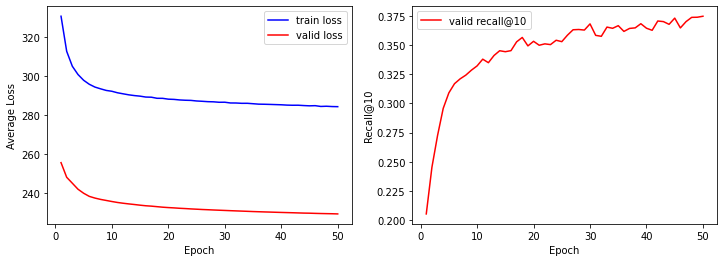

In [135]:
fig, (loss_ax, recall_ax) = plt.subplots(1,2, figsize=(12,4))

loss_ax.plot(range(1,new_epochs+1), train_loss_list, 'b', label='train loss')
loss_ax.plot(range(1,new_epochs+1), val_loss_list, 'r', label='valid loss')
recall_ax.plot(range(1,new_epochs+1), r10_fin_list, 'r', label='valid recall@10')

loss_ax.set_xticks(range(0, new_epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

recall_ax.set_xticks(range(0, new_epochs+1, 10))
recall_ax.set_xlabel('Epoch')
recall_ax.set_ylabel('Recall@10')
recall_ax.legend()

plt.show()

In [136]:
max(r10_fin_list)

0.37461759259259253

## MultiVAE 테스트 (TODO)

위의 MultiVAE 모델 코드, train, evaluate 함수를 완성하여, 아래 훈련 코드가 정상적으로 동작하도록 해보세요!

In [137]:

###############################################################################
# Load data
###############################################################################

loader = DataLoader(args.data)

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')

N = train_data.shape[0]
idxlist = list(range(N))

###############################################################################
# Build the model
###############################################################################

p_dims = [200, 3000, n_items]
model2 = MultiVAE(p_dims).to(device)

optimizer = adabound.AdaBound(model2.parameters(), lr=1e-3, final_lr=0.1)
#optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=args.wd)
criterion2 = loss_function_vae

###############################################################################
# Training code
###############################################################################

best_n100 = -np.inf
update_count = 0

In [138]:
train_loss_list = []
val_loss_list = []
r10_fin_list = []

best_r10 = -np.inf
# save best model as r10
for epoch in range(1, 50 + 1):
    epoch_start_time = time.time()
    train_loss = train(model2, criterion2, optimizer, is_VAE=True)
    val_loss, n100, r10, r20, r50 = evaluate(model2, criterion2, vad_data_tr, vad_data_te, is_VAE=True)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | '
            'n100 {:5.3f} | r10 {:5.3f} | r20 {:5.3f} | r50 {:5.3f}'.format(
                epoch, time.time() - epoch_start_time, val_loss,
                n100, r10, r20, r50))
    print('-' * 89)

    n_iter = epoch * len(range(0, N, args.batch_size))
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    r10_fin_list.append(r10)

    # Save the model if the r10 is the best we've seen so far.
    if r10 > best_r10:
        with open(args.save, 'wb') as f:
            torch.save(model2, f)
        best_r10 = r10
        print("Better performance! save best model...")



# Load the best saved model.
with open(args.save, 'rb') as f:
    model2 = torch.load(f)

# Run on test data.
test_loss, n100, r10, r20, r50 = evaluate(model2, criterion2, test_data_tr, test_data_te, is_VAE=True)
print('=' * 89)
print('| End of training | test loss {:4.2f} | n100 {:4.2f} | r10 {:4.2f} | r20 {:4.2f} | '
        'r50 {:4.2f}'.format(test_loss, n100, r10, r20, r50))
print('=' * 89)

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 2.29s | valid loss 255.91 | n100 0.256 | r10 0.192 | r20 0.189 | r50 0.239
-----------------------------------------------------------------------------------------
Better performance! save best model...
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 2.43s | valid loss 249.05 | n100 0.302 | r10 0.243 | r20 0.227 | r50 0.279
-----------------------------------------------------------------------------------------
Better performance! save best model...
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 2.38s | valid loss 245.01 | n100 0.337 | r10 0.273 | r20 0.254 | r50 0.309
-----------------------------------------------------------------------------------------
Better performance! save best model...
-------------------------------------

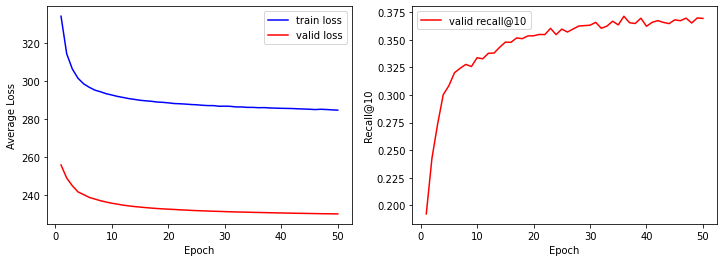

In [139]:
fig, (loss_ax, recall_ax) = plt.subplots(1,2, figsize=(12,4))

loss_ax.plot(range(1,new_epochs+1), train_loss_list, 'b', label='train loss')
loss_ax.plot(range(1,new_epochs+1), val_loss_list, 'r', label='valid loss')
recall_ax.plot(range(1,new_epochs+1), r10_fin_list, 'r', label='valid recall@10')

loss_ax.set_xticks(range(0, new_epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

recall_ax.set_xticks(range(0, new_epochs+1, 10))
recall_ax.set_xlabel('Epoch')
recall_ax.set_ylabel('Recall@10')
recall_ax.legend()

plt.show()

In [140]:
# test에 먼저 적용해보고 recall값 확인
N = test_data_tr.shape[0]
idxlist = list(range(N))

model.eval()
model2.eval()
total_loss = 0.0
e_idxlist = list(range(test_data_tr.shape[0]))
e_N = test_data_tr.shape[0]
pred_list = None

total_loss2 = 0
with torch.no_grad():
    for start_idx in range(0, e_N, args.batch_size):
        data_batch = test_data_tr

        data_tensor = naive_sparse2tensor(data_batch).to(device)
        data_tensor2 = naive_sparse2tensor(data_batch).to(device)

        if args.total_anneal_steps > 0:
            anneal = min(args.anneal_cap, 1. * update_count / args.total_anneal_steps)
        else:
            anneal = args.anneal_cap

        recon_batch2, mu, logvar = model2(data_tensor2)
        loss2 = criterion2(recon_batch2, data_tensor2, mu, logvar, anneal)
        total_loss2 += loss2.item()
        
        recon_batch = model(data_tensor)
        loss = criterion(recon_batch, data_tensor)
        total_loss += loss.item()

        # Exclude examples from training set
        recon_batch2 = recon_batch2.cpu().numpy()
        recon_batch = recon_batch.cpu().numpy()
        

        recon_batch = np.add(recon_batch, recon_batch2) # 1:1로 앙상블
        recon_batch[data_batch.nonzero()] = -np.inf

        # 여기에 감독 선호도 추가하면 될듯!
  
        ##Recall
        batch_users = recon_batch.shape[0]
        idx = bn.argpartition(-recon_batch, 10, axis=1)[:, :10]
        if start_idx == 0:
            pred_list = idx
        else:
            pred_list = np.append(pred_list, idx, axis=0)


In [141]:
print(np.mean(Recall_at_k_batch(recon_batch, test_data_te, k=10)))

0.3745814814814815


# 감독선호도 반영 예측

In [ ]:
with open('pref_item0.npy','rb') as f:
    pref_item0= np.load(f)
with open('pref_test0.npy','rb') as f:
    pref_test0= np.load(f)

In [334]:
# test에 먼저 적용해보고 recall값 확인

N = test_data_tr.shape[0]
idxlist = list(range(N))

model.eval()
model2.eval()
total_loss = 0.0
e_idxlist = list(range(test_data_tr.shape[0]))
e_N = test_data_tr.shape[0]
pred_list = None

total_loss2 = 0
with torch.no_grad():
    data_batch = test_data_tr

    data_tensor = naive_sparse2tensor(data_batch).to(device)
    data_tensor2 = naive_sparse2tensor(data_batch).to(device)

    if args.total_anneal_steps > 0:
        anneal = min(args.anneal_cap, 1. * update_count / args.total_anneal_steps)
    else:
        anneal = args.anneal_cap

    recon_batch2, mu, logvar = model2(data_tensor2)
    # loss2 = criterion2(recon_batch2, data_tensor2, mu, logvar, anneal)
    # total_loss2 += loss2.item()
    
    recon_batch = model(data_tensor)
    # loss = criterion(recon_batch, data_tensor)
    # total_loss += loss.item()

    # Exclude examples from training set
    recon_batch2 = recon_batch2.cpu().numpy()
    recon_batch = recon_batch.cpu().numpy()
    

    recon_batch = np.add(recon_batch, recon_batch2) # 1:1로 앙상블
    recon_batch[data_batch.nonzero()] = -np.inf
    # recon_batch= recon_batch**2

    # 여기에 감독 선호도 추가하면 될듯!
    recon_batch *= pref_test0
    
    ##Recall
    batch_users = recon_batch.shape[0]
    idx = bn.argpartition(-recon_batch, 10, axis=1)[:, :10]
    pred_list= idx

print(np.mean(Recall_at_k_batch(recon_batch, test_data_te, k=10)))

0.38673203656462585


## Submission

In [320]:
## 배치사이즈 포함
def numerize_for_infer(tp, profile2id, show2id):
    uid = tp['user'].apply(lambda x: profile2id[x])
    sid = tp['item'].apply(lambda x: show2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

### 데이터 준비    
infer_df = numerize_for_infer(raw_data, profile2id, show2id)

loader = DataLoader(args.data)
n_items = loader.load_n_items()

n_users = infer_df['uid'].max() + 1

rows, cols = infer_df['uid'], infer_df['sid']
data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, n_items))

N = data.shape[0]
idxlist = list(range(N))

model.eval()
model2.eval()
total_loss = 0.0
e_idxlist = list(range(data.shape[0]))
e_N = data.shape[0]
pred_list = None


In [321]:
total_loss2 = 0

with torch.no_grad():
    data_batch = data

    data_tensor = naive_sparse2tensor(data_batch).to(device)
    data_tensor2 = naive_sparse2tensor(data_batch).to(device)

    if args.total_anneal_steps > 0:
        anneal = min(args.anneal_cap, 1. * update_count / args.total_anneal_steps)
    else:
        anneal = args.anneal_cap

    recon_batch2, mu, logvar = model2(data_tensor2)
    # loss2 = criterion2(recon_batch2, data_tensor2, mu, logvar, anneal)
    # total_loss2 += loss2.item()
    
    recon_batch = model(data_tensor)
    # loss = criterion(recon_batch, data_tensor)
    # total_loss += loss.item()

    # Exclude examples from training set
    recon_batch2 = recon_batch2.cpu().numpy()
    recon_batch = recon_batch.cpu().numpy()
    

    recon_batch = np.add(recon_batch, recon_batch2) # 1:1로 앙상블
    recon_batch[data_batch.nonzero()] = -np.inf

    # 여기에 감독 선호도 추가하면 될듯!
    recon_batch *= pref_item0
    
    ##Recall
    batch_users = recon_batch.shape[0]
    idx = bn.argpartition(-recon_batch, 10, axis=1)[:, :10]
    pred_list= idx

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [322]:
pred_list.shape

(31360, 10)

In [323]:
## sample_submission에 맞게끔 바꾸기
user2 = []
item2 = []
for i_idx, arr_10 in enumerate(pred_list):
    user2.extend([i_idx]*10)
    item2.extend(arr_10)

u2 = pd.DataFrame(user2, columns=['user'])
i2 = pd.DataFrame(item2, columns=['item'])
all2 = pd.concat([u2, i2], axis=1)

re_p2id = dict((v, k) for k, v in profile2id.items())
re_s2id = dict((v, k) for k, v in show2id.items())

def de_numerize(tp, re_p2id, re_s2id):
    uid2 = tp['user'].apply(lambda x: re_p2id[x])
    sid2 = tp['item'].apply(lambda x: re_s2id[x])
    return pd.DataFrame(data={'uid': uid2, 'sid': sid2}, columns=['uid', 'sid'])

ans2 = de_numerize(all2, re_p2id, re_s2id)
ans2.columns = ['user', 'item']
new_ans2 = ans2.sort_values('user')

### 확인용
# submit_data = pd.read_csv('/content/code/output/sample_submission.csv', sep='\t')
# sum(new_ans2.user.values == submit_data.user.values)
new_ans2.reset_index(drop=True, inplace=True)
new_ans2.to_csv('./code/output/answer/dir_vae.csv', index=False)

In [324]:
new_ans2

,user,item
0,11,4370
1,11,3156
2,11,8961
3,11,53464
4,11,2
...,...,...
313595,138493,33615
313596,138493,32
313597,138493,2762
313598,138493,1258
